# 交叉验证

## 1 传统留出法的局限

第一，结果不确定性高

第二，数据利用不充分

# 2 交叉验证法介绍
2.1：K折交叉验证，留一交叉验证，留P交叉验证，分层交叉验证，时间序列交叉验证

2.2：模型选择和参数调优

### 2.1.1 K折交叉验证

10折交叉验证法步骤

第一步，将数据分成相等的10个字集

第二步，将9个子集用作训练集，剩下的1个子集用作验证集，计算均方误差

第三步，重复第二步10次，直到每个子集都被用作验证集

第四步，将所有验证集的均方误差进行平均

10折交叉验证法如下图所示

![10折交叉验证法](10折交叉验证图示.png)

与传统留出法的对比

In [175]:
# 导入第三方库
import pandas as pd
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize,poly)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

from functools import partial
from sklearn.model_selection import \
(TimeSeriesSplit,
StratifiedKFold,
LeavePOut,cross_validate,
KFold,
ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt

In [176]:
# 数据导入
Auto = load_data('Auto')
Auto = Auto.dropna()
print(Auto.shape)
Auto.head()

(392, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [177]:
# 使用循环计算传统留出法和10折交叉验证的MSE
ho_mse   = np.zeros(10)
cv10_mse = np.zeros(10)
# 单变量回归，自变量：马力
X        = np.array(Auto['horsepower']).reshape(-1, 1)
# 因变量，油耗里程
Y        = Auto['mpg']
for i in range(10):
    # 循环计算传统留出法的MSE
    # 将数据随机划分为2个相等的部分
    Auto_train, Auto_valid = train_test_split(Auto, test_size=196, random_state=i)
    # MS自动添加截距项
    hp_mm   = MS(['horsepower'])
    X_train = hp_mm.fit_transform(Auto_train)
    y_train = Auto_train['mpg']
    model   = sm.OLS(y_train, X_train)
    results = model.fit()
    X_valid = hp_mm.transform(Auto_valid)
    y_valid = Auto_valid['mpg']
    valid_pred = results.predict(X_valid)
    ho_mse[i]  = np.mean((y_valid - valid_pred)**2)
    # 循环计算10折交叉验证的MSE
    # shuffle 打乱数据的顺序
    cv   = KFold(n_splits=10, shuffle=True, random_state=i)
    M_CV = cross_validate(LinearRegression(), X, Y, cv   = cv, scoring ='neg_mean_squared_error')
    cv10_mse[i] = -np.mean(M_CV['test_score'])
print(ho_mse)
print(cv10_mse)

[23.61661707 24.80212062 23.44264397 20.75540796 25.31338198 29.58863543
 24.09679807 25.46790858 22.71253984 27.73037117]
[24.20766449 24.09767573 24.2117747  24.02802703 24.32768552 24.37450087
 24.24219692 24.20920149 24.2269402  24.37997721]


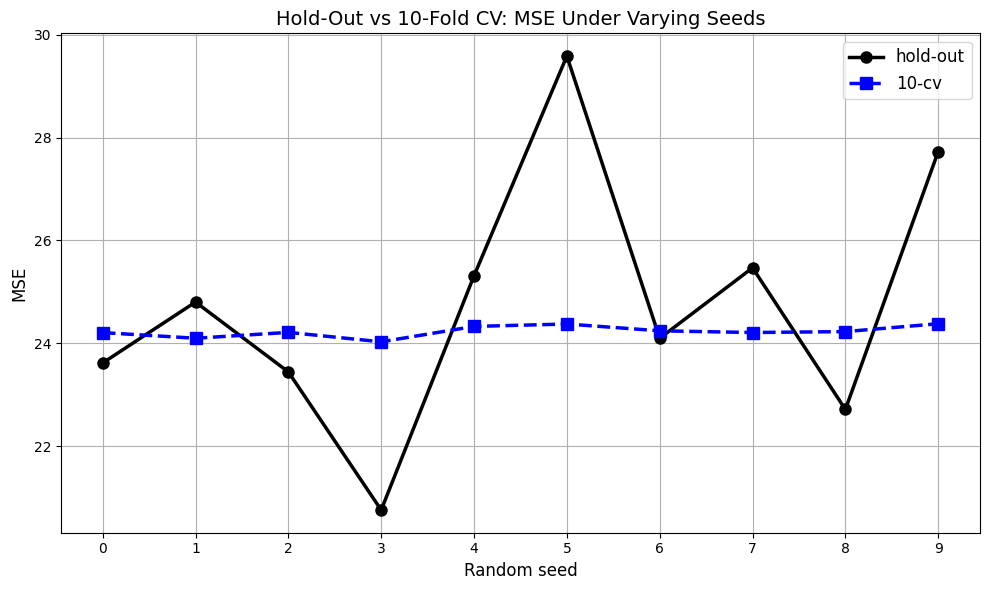

传统留出法的标准差：2.3803122231169094
10折交叉验证的标准差：0.10613080384890132


In [179]:
# 将留出法和10折交叉验证的MSE画到一张折线图上
plt.figure(figsize=(10, 6))
seeds = range(10)
plt.plot(seeds, ho_mse, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='black', label='hold-out')
plt.plot(seeds, cv10_mse, marker='s', linestyle='--', linewidth=2.5, markersize=8, color='blue', label='10-cv')

plt.xlabel('Random seed', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Hold-Out vs 10-Fold CV: MSE Under Varying Seeds', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(seeds)
plt.tight_layout()
plt.show()
print('传统留出法的标准差：{}'.format(ho_mse.std()))
print('10折交叉验证的标准差：{}'.format(cv10_mse.std()))

上图显示，交叉验证法在稳定性上有显著优势

### 2.1.2 留一交叉验证和留P交叉验证

留一交叉验证：每次使用1个样本作为验证集，其余所有样本作为训练集，例如样本量为N，则会产生N种样本划分的方式

留P交叉验证：每次使用P个样本作为验证集，其余样本作为训练集，若样本量为N，则会产生$C_N^P$种划分样本的方式

不受随机种子的影响，计算成本高

In [158]:
# 留一交叉验证和留P交叉验证的MSE

# 为节约计算时间，使用10个样本
X_sub = X[:10]
Y_sub = Y[:10]
lp_cv_mse = np.zeros(7)

# 循环计算MSE
for i in range(7):
    # p=1即为留1交叉验证
    lpo  = LeavePOut(p=i+1)
    M_CV = cross_validate(LinearRegression(), X_sub, Y_sub, cv=lpo, scoring='neg_mean_squared_error')
    lp_cv_mse[i] = -np.mean(M_CV['test_score'])

print(lp_cv_mse)

[ 0.01604399  0.97974269  1.85579516  1.77643613  2.45334162 12.71124235
  2.88829247]


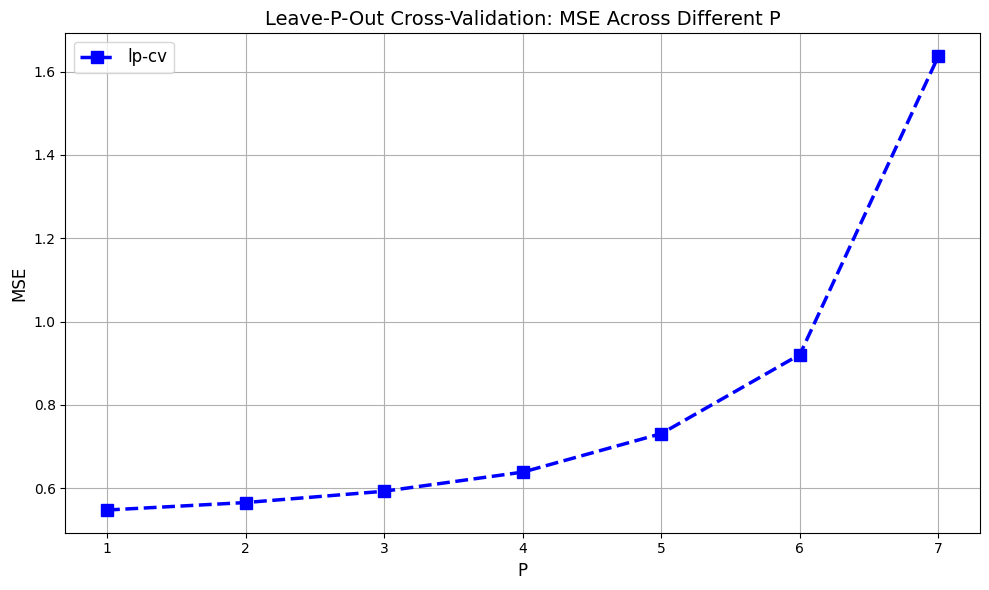

In [52]:
# 画出留p验证法的MSE图像
plt.figure(figsize=(10, 6))
p = range(1,8)
plt.plot(p, lp_cv_mse, marker='s', linestyle='--', linewidth=2.5, markersize=8, color='blue', label='lp-cv')

plt.xlabel('P', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Leave-P-Out Cross-Validation: MSE Across Different P', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(p)
plt.tight_layout()
plt.show()

MSE随着P值单调递增

### 2.1.3 分层交叉验证

核心思想：针对分类任务，保证每个样本子集中类别的比例与整个数据集相同

In [159]:
# 导入分类数据
Smarket = load_data('Smarket')
Smarket = Smarket.dropna()
print(Smarket.shape)
Smarket.head()

(1250, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [95]:
X = np.array(Smarket['Lag1']).reshape(-1, 1)
Y = Smarket.Direction == 'Up' 

scv10_mse = np.zeros(10)
cv10_mse  = np.zeros(10)
for i in range(10):
    # 分层10折交叉验证
    cv   = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    M_CV = cross_validate(LogisticRegression(), X, Y, cv=cv, scoring='accuracy')
    scv10_mse[i] = np.mean(M_CV['test_score'])
    # 传统10折交叉验证
    cv   = KFold(n_splits=10, shuffle=True, random_state=i)
    M_CV = cross_validate(LogisticRegression(), X, Y, cv = cv, scoring='accuracy')
    cv10_mse[i] = np.mean(M_CV['test_score'])
print(scv10_mse)
print(cv10_mse)

[0.5136 0.5176 0.5088 0.5216 0.516  0.5128 0.5192 0.5192 0.5104 0.5208]
[0.4952 0.5072 0.5088 0.5088 0.5104 0.5032 0.5168 0.5168 0.5064 0.5088]


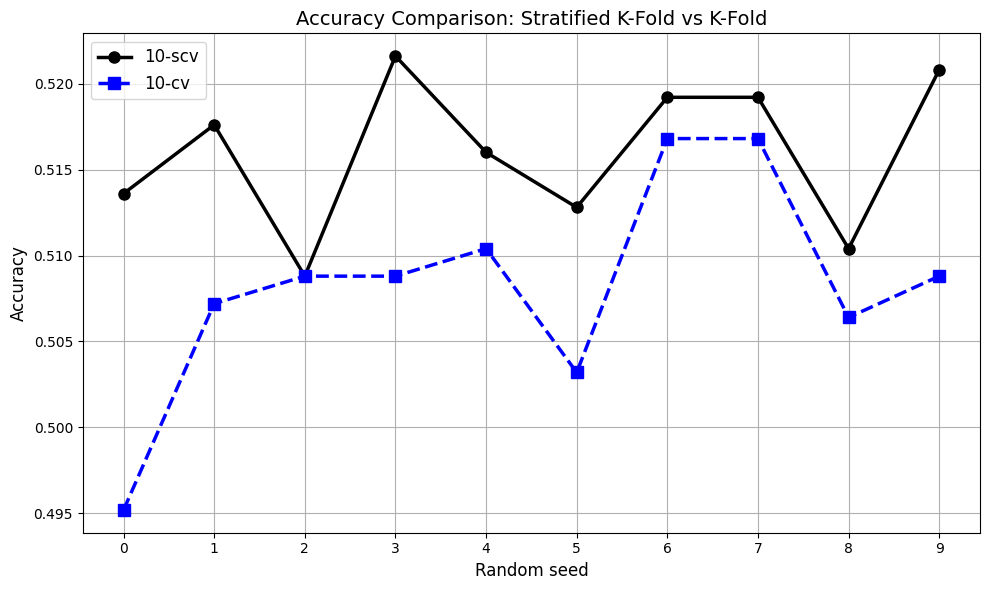

In [97]:
# 将10折交叉验证和分层10折交叉验证法的Accuracy画到一张折线图上
plt.figure(figsize=(10, 6))
seeds = range(10)
plt.plot(seeds, scv10_mse, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='black', label='10-scv')
plt.plot(seeds, cv10_mse, marker='s', linestyle='--', linewidth=2.5, markersize=8, color='blue', label='10-cv')

plt.xlabel('Random seed', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Comparison: Stratified K-Fold vs K-Fold', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(seeds)
plt.tight_layout()
plt.show()

分类任务中，分层交叉验证法比传统交叉验证表现略好

### 2.1.3 时间序列交叉验证

滚动窗口期：数据集大小固定，每次训练向前滑动一个时间点

拓展窗口期：训练集大小逐步增加，验证集大小固定，利用所有的历史数据进行训练

In [161]:
# 导入上证指数和收益率
SZ = pd.read_csv("SZ_Ret.csv")
SZ = SZ.dropna()
print(SZ.shape)
SZ.head()

(407, 9)


,Month,Ret,Ret_Lag1,Ret_Lag2,Ret_Lag3,Ret_Lag4,Ret_Lag5,Value_Lag,Vol_Lag
0,199105,0.007811,-0.052001,-0.096384,0.023390,0.018494,0.000000,3647.3,706.71
1,199106,0.197945,0.007811,-0.052001,-0.096384,0.023390,0.018494,3946.1,767.86
2,199107,0.045362,0.197945,0.007811,-0.052001,-0.096384,0.023390,4639.2,778.28
3,199108,0.240821,0.045362,0.197945,0.007811,-0.052001,-0.096384,8596.2,1601.32
4,199109,0.013955,0.240821,0.045362,0.197945,0.007811,-0.052001,4430.3,808.14


In [136]:
# 计算滚动窗口期、拓展窗口期和10折交叉验证法的MSE

X = np.array(SZ['Ret_Lag1']).reshape(-1, 1)
Y = SZ['Ret']

# 计算验证集大小
n_splits  = 10
n_samples = len(X)
val_size  = n_samples // (n_splits + 1)

# 计算滚动窗口期交叉验证法的MSE
tscv      = TimeSeriesSplit(n_splits=10,max_train_size=2*val_size)
M_CV      = cross_validate(LinearRegression(), X, Y, cv=tscv, scoring='neg_mean_squared_error')
roll_mse  = -np.mean(M_CV['test_score'])
print(roll_mse)

# 计算拓展窗口期交叉验证法的MSE
tscv       = TimeSeriesSplit(n_splits=10)
M_CV       = cross_validate(LinearRegression(), X, Y, cv=tscv, scoring='neg_mean_squared_error')
Expand_mse = -np.mean(M_CV['test_score'])

print(Expand_mse)



0.012152276440357723
0.01263670879595856


In [137]:
cv10_mse = np.zeros(10)
for i in range(10):
    cv          = KFold(n_splits=10, shuffle=True, random_state=i)
    M_CV        = cross_validate(LinearRegression(), X, Y, cv = cv, scoring ='neg_mean_squared_error')
    cv10_mse[i] = -np.mean(M_CV['test_score'])

print('滚动窗口期交叉验证法MSE：{}'.format(roll_mse))
print('拓展窗口期交叉验证法MSE：{}'.format(Expand_mse))
print('未考虑时间序列信息的10折交叉验证法MSE：{}'.format(cv10_mse.mean()))

滚动窗口期交叉验证法MSE：0.012152276440357723
拓展窗口期交叉验证法MSE：0.01263670879595856
未考虑时间序列信息的10折交叉验证法MSE：0.023382832105034092


## 2.2 交叉验证法的应用

### 2.2.1 模型选择（选择合适的多项式模型）

In [162]:
# 留一交叉验证
l1_error = np.zeros(5)
H = np.array(SZ['Ret_Lag1'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M, X, Y, cv=n_samples)
    l1_error[i] = np.mean(M_CV['test_score'])
l1_error

array([0.02340542, 0.02398805, 0.03216404, 0.51920518, 4.10641625])

In [163]:
# 10折交叉验证
cv10_error = np.zeros(5)
cv = KFold(n_splits=10, shuffle=True, random_state=0)
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M, X, Y, cv=cv)
    cv10_error[i] = np.mean(M_CV['test_score'])
cv10_error

array([2.35174005e-02, 1.06122755e-01, 3.86819742e+00, 1.01122200e+02,
       5.57256888e+02])

In [164]:
# 拓展窗口期时间序列交叉验证
expand_mse = np.zeros(5)
tscv       = TimeSeriesSplit(n_splits=10)
for i, d in enumerate(range(1,6)):
    X    = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M, X, Y, cv=tscv)
    expand_mse[i] = np.mean(M_CV['test_score'])
expand_mse

array([0.01263671, 0.01298304, 0.01248227, 0.12508434, 0.82429992])

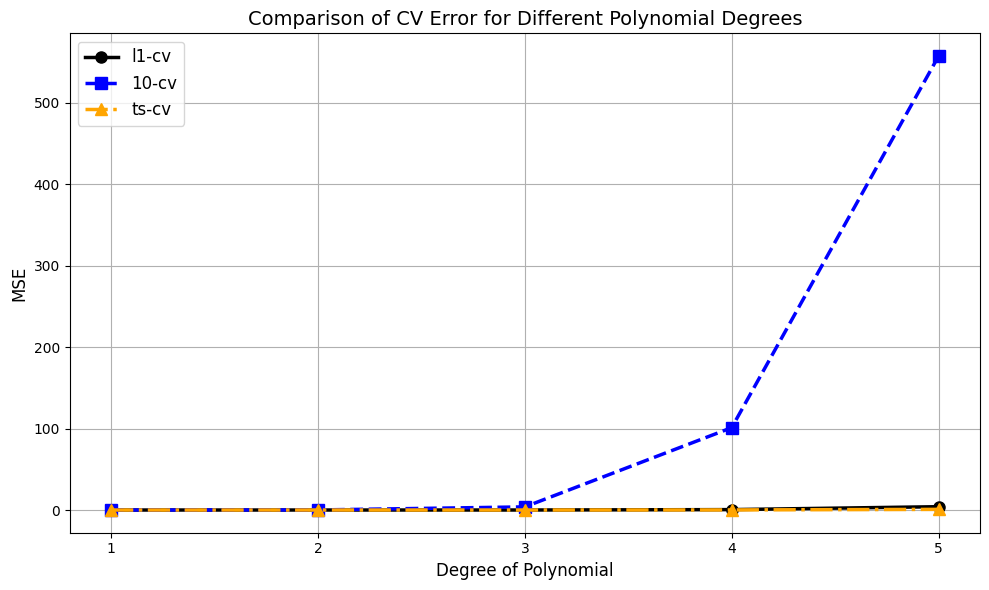

留一交叉验证选择的最优多项次系数为：1，对应的MSE为0.02340542475991644
10折交叉验证选择的最优多项次系数为：1，对应的MSE为0.02351740054301034
时间序列交叉验证选择的最优多项次系数为：3，对应的MSE为0.012482266143040708


In [166]:
# 将三种交叉验证法的模型选择结果画到一张图上
plt.figure(figsize=(10, 6))
degrees = range(1,6)
plt.plot(degrees, l1_error, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='black', label='l1-cv')
plt.plot(degrees, cv10_error, marker='s', linestyle='--', linewidth=2.5, markersize=8, color='blue', label='10-cv')
plt.plot(degrees, expand_mse, marker='^', linestyle='-.', linewidth=2.5, markersize=8, color='orange', label='ts-cv')

plt.xlabel('Degree of Polynomial', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Comparison of CV Error for Different Polynomial Degrees', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(degrees)
plt.tight_layout()
plt.show()

print('留一交叉验证选择的最优多项次系数为：{}，对应的MSE为{}'.format(np.argmin(l1_error)+1,np.min(l1_error)))
print('10折交叉验证选择的最优多项次系数为：{}，对应的MSE为{}'.format(np.argmin(cv10_error)+1,np.min(cv10_error)))
print('时间序列交叉验证选择的最优多项次系数为：{}，对应的MSE为{}'.format(np.argmin(expand_mse)+1,np.min(expand_mse)))

### 2.2.2 Ridge参数调优

In [168]:
# 自变量和惩罚系数标准化，设置10个备选系数
X = SZ.drop(columns='Ret')
X = np.asarray(X)
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]
lambdas = np.linspace(0.001,1,10)/ Y.std()

In [169]:
# 留一交叉验证
l1_error = np.zeros(10)
for i in range(10):
    M_CV = cross_validate(Ridge(alpha=lambdas[i]), Xs, Y, cv=n_samples, scoring='neg_mean_squared_error')
    l1_error[i] = -np.mean(M_CV['test_score'])
l1_error

array([0.02394817, 0.02393919, 0.02393864, 0.02394187, 0.02394665,
       0.02395192, 0.02395714, 0.02396203, 0.02396649, 0.02397047])

In [173]:
# 10折交叉验证
cv10_error = np.zeros(10)
cv = KFold(n_splits=5, shuffle=True, random_state=0) 
for i in range(10):
    M_CV = cross_validate(Ridge(alpha=lambdas[i]), Xs, Y, cv=cv, scoring='neg_mean_squared_error')
    cv10_error[i] = -np.mean(M_CV['test_score'])
cv10_error

array([0.02338314, 0.0233813 , 0.0233881 , 0.02339751, 0.02340721,
       0.02341631, 0.0234245 , 0.0234317 , 0.02343797, 0.02344337])

In [170]:
# 拓展窗口期时间序列交叉验证
expand_mse = np.zeros(10)
tscv       = TimeSeriesSplit(n_splits=10)
for i in range(10):
    M_CV = cross_validate(Ridge(alpha=lambdas[i]), Xs, Y, cv=tscv, scoring='neg_mean_squared_error')
    expand_mse[i] = -np.mean(M_CV['test_score'])
expand_mse

array([0.03154428, 0.01437563, 0.01408748, 0.01399983, 0.01392599,
       0.01385348, 0.01378336, 0.0137171 , 0.01365548, 0.01359871])

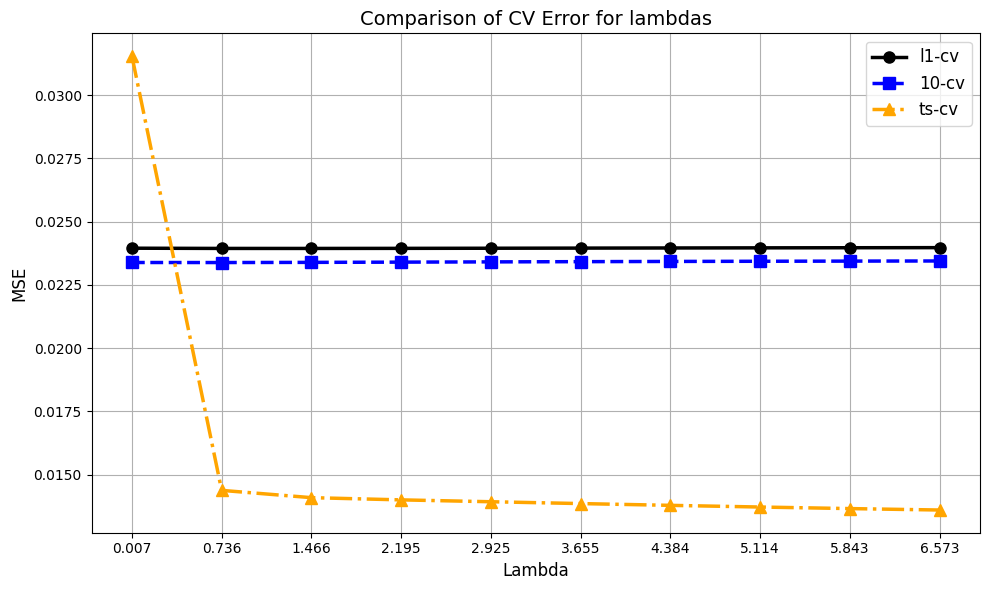

留一交叉验证选择的最优惩罚系数为：3，对应的MSE为0.02393864099628079
10折交叉验证选择的最优惩罚系数为：2，对应的MSE为0.0233813039712863
时间序列交叉验证选择的最优惩罚系数为：10，对应的MSE为0.013598712715632216


In [174]:
# 将三种交叉验证法的模型选择结果画到一张图上
plt.figure(figsize=(10, 6))
plt.plot(lambdas, l1_error, marker='o', linestyle='-', linewidth=2.5, markersize=8, color='black', label='l1-cv')
plt.plot(lambdas, cv10_error, marker='s', linestyle='--', linewidth=2.5, markersize=8, color='blue', label='10-cv')
plt.plot(lambdas, expand_mse, marker='^', linestyle='-.', linewidth=2.5, markersize=8, color='orange', label='ts-cv')

plt.xlabel('Lambda', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Comparison of CV Error for lambdas', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(lambdas)
plt.tight_layout()
plt.show()

print('留一交叉验证选择的最优惩罚系数为：{}，对应的MSE为{}'.format(np.argmin(l1_error)+1,np.min(l1_error)))
print('10折交叉验证选择的最优惩罚系数为：{}，对应的MSE为{}'.format(np.argmin(cv10_error)+1,np.min(cv10_error)))
print('时间序列交叉验证选择的最优惩罚系数为：{}，对应的MSE为{}'.format(np.argmin(expand_mse)+1,np.min(expand_mse)))

# 总结

第一，交叉验证法相对于传统留出法有明显优势

第二，对于分类任务，分层K折验证法表现更优

第三，对于时间序列数据，时间序列交叉验证法表现更优